# Neural Color Transfer (Multi-Reference Style Transfer)

## Library

In [1]:
#Append 'src' direc to import modules from notebooks directory#
##################################################
#import os,sys
#src_dir=os.path.join(os.getcwd(),os.pardir)
#sys.path.append(src_dir)
#################################################

In [2]:
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
import matplotlib as plt
import time
import os
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
from torchvision import transforms
from torchvision.utils import make_grid
from collections import OrderedDict
from PIL import Image,ImageOps
import torch.optim as optim
import scipy
from skimage import color

## Input Source & Reference Image

In [4]:
USE_CUDA = True  # or False if you don't have CUDA
FEATURE_IDS = [1, 6, 11, 20, 29]

imgS_path = './image/3_Source1.jpg'
imgR_path = './image/3_Reference.jpg'

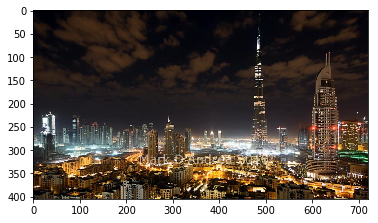

In [5]:
# Checking
origS = Image.open(imgS_path).convert("RGB")
imshow(origS)

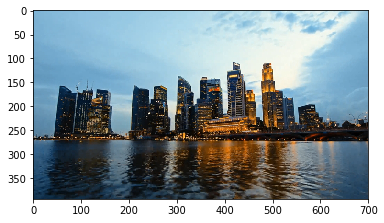

In [6]:
# Checking
origR = Image.open(imgR_path).convert("RGB")
imshow(origR)

## Image Loader

In [7]:
def image_loader(img_path, flip=False):
    img = Image.open(img_path).convert("RGB")
    if flip:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)

    data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    img_tensor = data_transforms(img)
    img_tensor = img_tensor.unsqueeze(0)
    return img_tensor

def tsshow(img_tensor):
    img_np = img_tensor.squeeze().numpy().transpose(1, 2, 0)
    imshow(img_np)  #, interpolation = 'nearest')

In [8]:
imgS=image_loader(imgS_path, flip=False)
imgR=image_loader(imgR_path, flip=False)

imgS_np = imgS.squeeze().numpy().transpose(1, 2, 0)
imgR_np = imgR.squeeze().numpy().transpose(1, 2, 0)

In [9]:
# Checking
print(imgS.size())  # (1, 3, SHeight, SWidth)
print(imgR.size())  # (1, 3, RHeight, RWidth)
print(imgS.dtype, imgR.dtype, "\n")  # torch.float32

print(imgS_np.shape)  # (SHeight, SWidth, 3)
print(imgR_np.shape, "\n")  # (RHeight, RWidth, 3)

# Verifying normalization
print("Original S's mean:", np.asarray(origS).mean(axis=(0, 1)))
print("Original S's std:", np.asarray(origS).std(axis=(0, 1)))
print("Normalized S's mean:", imgS_np.mean(axis=(0, 1)))
print("Normalized S's std:", imgS_np.std(axis=(0, 1)), "\n")

print("Original R's mean:", np.asarray(origR).mean(axis=(0, 1)))
print("Original R's std:", np.asarray(origR).std(axis=(0, 1)))
print("Normalized R's mean:", imgR_np.mean(axis=(0, 1)))
print("Normalized R's std:", imgR_np.std(axis=(0, 1)))

torch.Size([1, 3, 405, 720])
torch.Size([1, 3, 394, 700])
torch.float32 torch.float32 

(405, 720, 3)
(394, 700, 3) 

Original S's mean: [61.62190329 50.21784294 41.66634088]
Original S's std: [57.8738523  52.01588416 45.43425297]
Normalized S's mean: [-1.0626439 -1.15655   -1.0782337]
Normalized S's std: [0.99107546 0.9106422  0.79188246] 

Original R's mean: [109.97153009 127.81088107 135.57476432]
Original R's std: [67.65980285 78.28225721 87.38713418]
Normalized R's mean: [-0.23466858  0.20187134  0.5585145 ]
Normalized R's std: [1.1586574 1.3704876 1.5230874]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


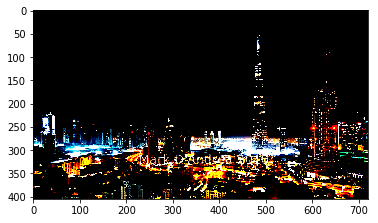

In [10]:
# Checking
tsshow(imgS)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


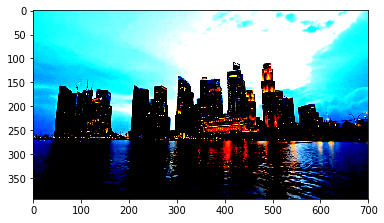

In [11]:
# Checking
tsshow(imgR)

## Process
From S_6 = S_(L+1) to S_1(Final Result)

Feature Domain
    > FeatureExtractor
    > PatchMatch
    > BDS Voting

Image Domain
    > Resolution equal
    > Local Color Transfer

## FeatureExtractor

In [12]:
class FeatureExtractor(nn.Sequential):
    def __init__(self):
        super(FeatureExtractor, self).__init__()

    def add_layer(self, name, layer):
        self.add_module(name, layer)

    def forward(self, x, feature_id):
        for idx, module in enumerate(self._modules):
            x = self._modules[module](x)
            if idx == feature_id:
                return x

In [13]:
vgg_temp = models.vgg19(pretrained=True).features
model = FeatureExtractor()  # The new Feature Extractor module network

conv_counter = 1
relu_counter = 1

block_counter = 1

for i, layer in enumerate(list(vgg_temp)):
    if isinstance(layer, nn.Conv2d):
        name = "conv_" + str(block_counter) + "_" + str(conv_counter)
        conv_counter += 1
        model.add_layer(name, layer)

    if isinstance(layer, nn.ReLU):
        name = "relu_" + str(block_counter) + "_" + str(relu_counter)
        relu_counter += 1
        model.add_layer(name, layer)

    if isinstance(layer, nn.MaxPool2d):
        name = "pool_" + str(block_counter) 
        bn_counter = relu_counter = conv_counter = 1
        block_counter += 1
        model.add_layer(name, layer)  # Is nn.AvgPool2d((2,2)) better than nn.MaxPool2d?

if USE_CUDA:
    model.cuda('cuda:3')

In [14]:
# Checking
print(model)
print([list(model._modules)[idx] for idx in FEATURE_IDS])

FeatureExtractor(
  (conv_1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1_1): ReLU(inplace)
  (conv_1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1_2): ReLU(inplace)
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2_1): ReLU(inplace)
  (conv_2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2_2): ReLU(inplace)
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_1): ReLU(inplace)
  (conv_3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_2): ReLU(inplace)
  (conv_3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_3): ReLU(inplace)
  (conv_3_4): Conv2d(256, 256, kernel_size=(

In [15]:
def get_feature(img_tensor, feature_id):
    if USE_CUDA:
        img_tensor = img_tensor.cuda('cuda:3')

    feature = model(img_tensor, feature_id)
    feature = feature.data.squeeze().cpu().numpy().transpose(1, 2, 0)
    return np.array(feature)

def normalize(feature):
    return feature / np.linalg.norm(feature, ord=2, axis=2, keepdims=True)

In [16]:
feat5S = get_feature(imgS, FEATURE_IDS[4])
feat5R = get_feature(imgR, FEATURE_IDS[4])
feat5S_norm = normalize(feat5S)
feat5R_norm = normalize(feat5R)

In [17]:
# Checking
print(feat5S.shape)
print(feat5R.shape)

(25, 45, 512)
(24, 43, 512)


In [18]:
# (IN PROGRESS)
# EXPERIMENTAL
class DeepDream:
    """
        Produces an image that minimizes the loss of a convolution
        operation for a specific layer and filter
    """
    def __init__(self, model, selected_layer, selected_filter, im_path):
        self.model = model
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.conv_output = 0
        self.image = image_loader(im_path, flip=False)

        if USE_CUDA:
            self.model.cuda('cuda:3')
            self.image = self.image.cuda('cuda:3')

        self.image.requires_grad_()
        # Hook the layers to get result of the convolution
        self.hook_layer()

    def hook_layer(self):
        def hook_function(module, grad_in, grad_out):
            # Get the conv output of the selected filter (from selected layer)
            self.conv_output = grad_out[0, self.selected_filter]

        # Hook the selected layer
        self.model[self.selected_layer].register_forward_hook(hook_function)

    def dream(self):
        # Define optimizer for the image
        # Earlier layers need higher learning rates to visualize whereas lower layers need less
        optimizer = optim.SGD([self.image], lr=12, weight_decay=1e-4)
        # optimizer = optim.Adam([self.image], lr=0.1, weight_decay=1e-6)
        for i in range(1, 251):
            optimizer.zero_grad()
            # Assign image to a variable to move forward in the model
            x = self.image
            for index, layer in enumerate(self.model):
                # Forward
                x = layer(x)
                # Only need to forward until the selected layer is reached
                if index == self.selected_layer:
                    break
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)
            if i % 10 == 0:
                print("Iteration:", str(i) + "/250", "Loss:", "{0:.2f}".format(loss.data.cpu().numpy()))
            # Backward
            loss.backward()
            # Update image
            optimizer.step()

Iteration: 10/250 Loss: -21.25
Iteration: 20/250 Loss: -56.55
Iteration: 30/250 Loss: -85.62
Iteration: 40/250 Loss: -110.38
Iteration: 50/250 Loss: -132.78
Iteration: 60/250 Loss: -153.31
Iteration: 70/250 Loss: -172.35
Iteration: 80/250 Loss: -190.09
Iteration: 90/250 Loss: -206.54
Iteration: 100/250 Loss: -221.93
Iteration: 110/250 Loss: -236.68
Iteration: 120/250 Loss: -250.73
Iteration: 130/250 Loss: -264.05
Iteration: 140/250 Loss: -277.05
Iteration: 150/250 Loss: -289.53
Iteration: 160/250 Loss: -301.58
Iteration: 170/250 Loss: -313.25
Iteration: 180/250 Loss: -324.68
Iteration: 190/250 Loss: -335.95
Iteration: 200/250 Loss: -346.91
Iteration: 210/250 Loss: -357.66
Iteration: 220/250 Loss: -368.27
Iteration: 230/250 Loss: -378.75
Iteration: 240/250 Loss: -389.03


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration: 250/250 Loss: -399.19


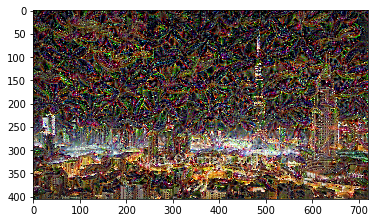

In [19]:
# (IN PROGRESS)
# EXPERIMENTAL
cnn_layer = FEATURE_IDS[4]
filter_pos = 94
dd = DeepDream(vgg_temp, cnn_layer, filter_pos, imgS_path)
# This operation can also be done without Pytorch hooks
# See layer visualisation for the implementation without hooks
dd.dream()

dd_image_np = dd.image.detach().squeeze().cpu().numpy().transpose(1, 2, 0)
imshow(dd_image_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406])

## PatchMatch

In [20]:
class PatchMatch: 
    def __init__(self, a, b, patch_size=3):
        self.a = a
        self.b = b
        self.ah = a.shape[0]
        self.aw = a.shape[1]
        self.bh = b.shape[0]
        self.bw = b.shape[1]
        self.patch_size = patch_size

        self.nnf = np.zeros((self.ah, self.aw, 2)).astype(np.int)  # The NNF
        self.nnd = np.zeros((self.ah, self.aw))  # The NNF distance map
        self.init_nnf()

    def init_nnf(self):
        for ay in range(self.ah):
            for ax in range(self.aw):
                by = np.random.randint(self.bh)
                bx = np.random.randint(self.bw)
                self.nnf[ay, ax] = [by, bx]
                self.nnd[ay, ax] = self.calc_dist(ay, ax, by, bx)

    def calc_dist(self, ay, ax, by, bx):
        """
            Measure distance between 2 patches across all channels
            ay : y coordinate of a patch in a
            ax : x coordinate of a patch in a
            by : y coordinate of a patch in b
            bx : x coordinate of a patch in b
        """
        dy0 = dx0 = self.patch_size // 2
        dy1 = dx1 = self.patch_size // 2 + 1
        dy0 = min(ay, by, dy0)
        dy1 = min(self.ah - ay, self.bh - by, dy1)
        dx0 = min(ax, bx, dx0)
        dx1 = min(self.aw - ax, self.bw - bx, dx1)

        dist = np.sum(np.square(self.a[ay - dy0:ay + dy1, ax - dx0:ax + dx1] - self.b[by - dy0:by + dy1, bx - dx0:bx + dx1]))
        dist /= ((dy0 + dy1) * (dx0 + dx1))
        return dist

    def improve_guess(self, ay, ax, by, bx, ybest, xbest, dbest):
        d = self.calc_dist(ay, ax, by, bx)
        if d < dbest:
            ybest, xbest, dbest = by, bx, d
        return ybest, xbest, dbest

    def improve_nnf(self, total_iter=5):
        for iter in range(total_iter):
            if iter % 2:
                ystart, yend, ychange = self.ah - 1, -1, -1
                xstart, xend, xchange = self.aw - 1, -1, -1
            else:
                ystart, yend, ychange = 0, self.ah, 1
                xstart, xend, xchange = 0, self.aw, 1

            for ay in range(ystart, yend, ychange):
                for ax in range(xstart, xend, xchange):
                    ybest, xbest = self.nnf[ay, ax]
                    dbest = self.nnd[ay, ax]

                    # Propagation
                    if (ay - ychange) < self.ah and (ay - ychange) >= 0:
                        yp, xp = self.nnf[ay - ychange, ax]
                        yp += ychange
                        if yp < self.bh and yp >= 0:
                            ybest, xbest, dbest = self.improve_guess(ay, ax, yp, xp, ybest, xbest, dbest)
                    if (ax - xchange) < self.aw and (ax - xchange) >= 0:
                        yp, xp = self.nnf[ay, ax - xchange]
                        xp += xchange
                        if xp < self.bw and xp >= 0:
                            ybest, xbest, dbest = self.improve_guess(ay, ax, yp, xp, ybest, xbest, dbest)

                    # Random search
                    rand_d = max(self.bh, self.bw)
                    while rand_d >= 1:
                        ymin, ymax = max(ybest - rand_d, 0), min(ybest + rand_d, self.bh)
                        xmin, xmax = max(xbest - rand_d, 0), min(xbest + rand_d, self.bw)
                        yp = np.random.randint(ymin, ymax)
                        xp = np.random.randint(xmin, xmax)
                        ybest, xbest, dbest = self.improve_guess(ay, ax, yp, xp, ybest, xbest, dbest)
                        rand_d = rand_d // 2

                    self.nnf[ay, ax] = [ybest, xbest]
                    self.nnd[ay, ax] = dbest
            print("iteration:", str(iter + 1) + "/" + str(total_iter))

    def solve(self):
        self.improve_nnf(total_iter=5)

In [21]:
map5SR = PatchMatch(feat5S_norm, feat5R_norm) #S -> R
map5RS = PatchMatch(feat5R_norm, feat5S_norm) #R -> S
map5SR.solve()
print()
map5RS.solve()

iteration: 1/5
iteration: 2/5
iteration: 3/5
iteration: 4/5
iteration: 5/5

iteration: 1/5
iteration: 2/5
iteration: 3/5
iteration: 4/5
iteration: 5/5


In [22]:
# Checking
print(map5SR.nnf.shape)
print(map5SR.nnd.shape, "\n")

print(map5RS.nnf.shape)
print(map5RS.nnd.shape)

(25, 45, 2)
(25, 45) 

(24, 43, 2)
(24, 43)


## Image Resizing

In [23]:
def image_to_tensor(img, img_transforms=[]):
    data_transforms = transforms.Compose(img_transforms + [
        transforms.ToTensor(),
    ])
    img_tensor = data_transforms(img)
    return img_tensor

def resize_img(img, size):
    return image_to_tensor(img, [transforms.Resize(size)])

In [24]:
imgS_resized = resize_img(origS, feat5S.shape[:2])
imgR_resized = resize_img(origR, feat5R.shape[:2])

In [25]:
# Checking
print(imgS_resized.size())
print(imgR_resized.size())

torch.Size([3, 25, 45])
torch.Size([3, 24, 43])


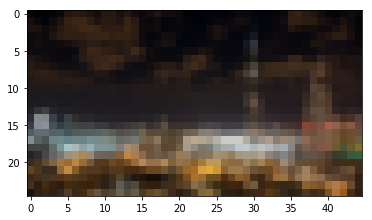

In [26]:
# Checking
tsshow(imgS_resized)

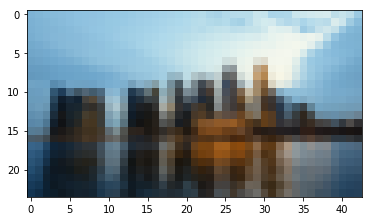

In [27]:
# Checking
tsshow(imgR_resized)

## BDS Voting (Reconstruct) (수정필요)

In [28]:
def bds_vote(snn, rnn, snnd, rnnd, src, patchsize=3):
    """
    Reconstructs an image or feature map by bidirectionaly
    similarity voting
    """

    src_height = src.shape[1]   # C * H * W
    src_width = src.shape[2]
    channels = src.shape[0]
    print("src_height: " + str(src_height))
    print("src_width: " + str(src_width))

    dest_height = snn.shape[1]
    dest_width = snn.shape[2]
    dest = np.zeros((channels, dest_height, dest_width))

    print("dest_height: " + str(dest_height))
    print("dest_width: " + str(dest_width))

    pmax = patchsize // 2

    weights = np.zeros((dest_height, dest_width))
    ws = 1 / (snn.shape[1] * snn.shape[2])  # (dest_height * dest_width)
    wr = 1 / (rnn.shape[1] * rnn.shape[2])  # (src_height * src_width)

    # coherence
    # The S->R forward NNF enforces coherence
    for i in range(dest_height):
        for j in range(dest_width):
            py = snn[0, i, j]
            px = snn[1, i, j]

            for dy in range(-pmax, pmax + 1):
                if i + dy < 0:
                    continue
                if i + dy >= dest_height:
                    break
                if py + dy < 0:
                    continue
                if py + dy >= src_height:
                    break
                for dx in range(-pmax, pmax + 1):
                    if j + dx < 0:
                        continue
                    if j + dx >= dest_width:
                        break
                    if px + dx < 0:
                        continue
                    if px + dx >= src_width:
                        break
                    dest[:, i + dy, j + dx] += ws * src[:, py + dy, px + dx]
                    weights[i + dy, j + dx] += ws


    # completeness
    # The R->S backward NNF enforces completeness
    for i in range(src_height):
        for j in range(src_width):
            py = rnn[0, i, j]
            px = rnn[1, i, j]

            for dy in range(-pmax, pmax + 1):
                if i + dy < 0:
                    continue
                if i + dy >= src_height:
                    break
                if py + dy < 0:
                    continue
                if py + dy >= dest_height:
                    break
                for dx in range(-pmax, pmax + 1):
                    if j + dx < 0:
                        continue
                    if j + dx >= src_width:
                        break
                    if px + dx < 0:
                        continue
                    if px + dx >= dest_width:
                        break
                    dest[:, py + dy, px + dx] += wr * src[:, i + dy, j + dx]
                    weights[py + dy, px + dx] += wr

    for y in range(dest_height):
        for x in range(dest_width):
            s = 1 if weights[y, x] == 0 else (1 / weights[y, x])
            dest[:, y, x] *= s

    return dest

In [29]:
imgG = bds_vote(map5SR.nnf.transpose(2, 0, 1), map5RS.nnf.transpose(2, 0, 1), map5SR.nnd, map5RS.nnd, imgR_resized)
feat5G = bds_vote(map5SR.nnf.transpose(2, 0, 1), map5RS.nnf.transpose(2, 0, 1), map5SR.nnd, map5RS.nnd, feat5R.transpose(2, 0, 1))
feat5G = feat5G.transpose(1, 2, 0)
feat5G_norm = normalize(feat5G)
print(imgG)
print(imgG.shape)

src_height: 24
src_width: 43
dest_height: 25
dest_width: 45
src_height: 24
src_width: 43
dest_height: 25
dest_width: 45
[[[0.77647063 0.67058827 0.67450982 ... 0.42222224 0.39869282 0.3411765 ]
  [0.81960786 0.77254906 0.75196078 ... 0.39738563 0.38431373 0.33098041]
  [0.81699347 0.82440089 0.82047933 ... 0.40348584 0.43305324 0.43333334]
  ...
  [0.21126998 0.21102037 0.27712419 ... 0.27407408 0.28932463 0.30000002]
  [0.10588235 0.13943356 0.25795209 ... 0.38213509 0.2888889  0.25163399]
  [0.11568628 0.1503268  0.30653597 ... 0.34901963 0.2261438  0.18039216]]

 [[0.89411765 0.83529411 0.83921573 ... 0.4130719  0.42352943 0.39411765]
  [0.9137255  0.88431372 0.87500003 ... 0.38910676 0.4019608  0.38431373]
  [0.90718955 0.91285403 0.91111111 ... 0.40435731 0.46834735 0.50490196]
  ...
  [0.1779492  0.1812813  0.27102398 ... 0.17777778 0.2335512  0.26601307]
  [0.09215686 0.11851852 0.23660132 ... 0.29934641 0.2932462  0.28366015]
  [0.10294118 0.12418301 0.22483661 ... 0.27320262 0

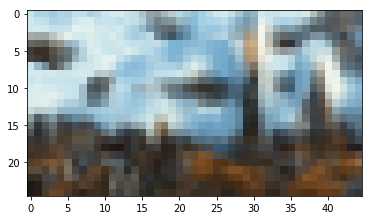

In [30]:
# Checking
imshow(imgG.transpose(1, 2, 0))

## Affine Transfrom

In [31]:
labS = color.rgb2lab(imgS_resized.numpy().transpose(1, 2, 0))
labG = color.rgb2lab(imgG.transpose(1, 2, 0))

In [32]:
# Checking
print(labS.shape)
print(labG.shape)

(25, 45, 3)
(25, 45, 3)


In [33]:
class LocalColorTransfer:
    def __init__(self, s, g, featS_norm, featG_norm, patch_size=3):
        self.source = torch.from_numpy(s.transpose(2, 0, 1)).float()
        self.guide = torch.from_numpy(g.transpose(2, 0, 1)).float()
        self.featS_norm = torch.from_numpy(featS_norm.transpose(2, 0, 1)).float()
        self.featG_norm = torch.from_numpy(featG_norm.transpose(2, 0, 1)).float()
        self.height = s.shape[0]
        self.width = s.shape[1]
        self.patch_size = patch_size

        self.paramA = torch.zeros(self.source.size())
        self.paramB = torch.zeros(self.source.size())
        
        if USE_CUDA:
            self.source = self.source.cuda('cuda:3')
            self.guide = self.guide.cuda('cuda:3')
            self.featS_norm = self.featS_norm.cuda('cuda:3')
            self.featG_norm = self.featG_norm.cuda('cuda:3')
            self.paramA = self.paramA.cuda('cuda:3')
            self.paramB = self.paramB.cuda('cuda:3')
        self.init_params()

    def init_params(self):
        """
            Initialize a and b from source and guidance using mean and std
        """
        eps = 0.002
        for y in range(self.height):
            for x in range(self.width):
                dy0 = dx0 = self.patch_size // 2
                dy1 = dx1 = self.patch_size // 2 + 1
                dy0 = min(y, dy0)
                dy1 = min(self.height - y, dy1)
                dx0 = min(x, dx0)
                dx1 = min(self.width - x, dx1)

                patchS = self.source[:, y - dy0:y + dy1, x - dx0:x + dx1].contiguous().view(3, -1)
                patchG = self.guide[:, y - dy0:y + dy1, x - dx0:x + dx1].contiguous().view(3, -1)
                self.paramA[:, y, x] = patchG.std(1) / (patchS.std(1) + eps)
                self.paramB[:, y, x] = patchG.mean(1) - self.paramA[:, y, x] * patchS.mean(1)
        self.paramA.requires_grad_()
        self.paramB.requires_grad_()

    def visualize(self):
        transfered = self.paramA * self.source + self.paramB
        imshow(color.lab2rgb(transfered.detach().cpu().numpy().transpose(1, 2, 0)))

    def train(self, total_iter=250):
        optimizer = optim.Adam([self.paramA, self.paramB], lr=0.1, weight_decay=0)
        for iter in range(total_iter):
            optimizer.zero_grad()

            error = torch.pow(self.featS_norm - self.featG_norm, 2)
            transfered = self.paramA * self.source + self.paramB
            term1 = torch.sum(1 - error / error.norm(2, 0, keepdim=True), 0)
            term2 = torch.pow(transfered - self.guide, 2).sum(0)
            loss_d = torch.mean(term1 * term2)
            loss = loss_d

            if (iter + 1) % 10 == 0:
                print("Iteration:", str(iter + 1) + "/" + str(total_iter), "Loss:", "{0:.4f}".format(loss.data.cpu().numpy()))
            loss.backward()
            optimizer.step()

In [34]:
lct = LocalColorTransfer(labS, labG, feat5S_norm, feat5G_norm)

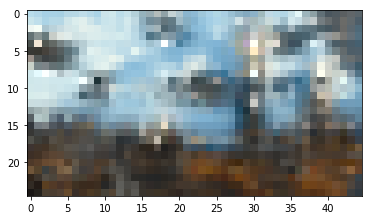

In [35]:
lct.visualize()

Iteration: 10/250 Loss: 14329.6338
Iteration: 20/250 Loss: 6445.5405
Iteration: 30/250 Loss: 3499.5488
Iteration: 40/250 Loss: 1898.7991
Iteration: 50/250 Loss: 1139.9043
Iteration: 60/250 Loss: 748.8214
Iteration: 70/250 Loss: 501.2480
Iteration: 80/250 Loss: 345.0899
Iteration: 90/250 Loss: 240.9036
Iteration: 100/250 Loss: 169.5887
Iteration: 110/250 Loss: 119.9864
Iteration: 120/250 Loss: 85.2493
Iteration: 130/250 Loss: 60.7896
Iteration: 140/250 Loss: 43.4619
Iteration: 150/250 Loss: 31.1088
Iteration: 160/250 Loss: 22.2593
Iteration: 170/250 Loss: 15.8949
Iteration: 180/250 Loss: 11.3089
Iteration: 190/250 Loss: 8.0045
Iteration: 200/250 Loss: 5.6289
Iteration: 210/250 Loss: 3.9281
Iteration: 220/250 Loss: 2.7177
Iteration: 230/250 Loss: 1.8626
Iteration: 240/250 Loss: 1.2638
Iteration: 250/250 Loss: 0.8485


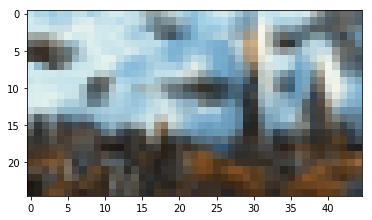

In [36]:
lct.train()
lct.visualize()

## WLS Filter

In [37]:
from guided_filter_pytorch.guided_filter import FastGuidedFilter
labOrigS = torch.from_numpy(color.rgb2lab(np.array(origS)).transpose(2, 0, 1)).float()
a_upsampled = FastGuidedFilter(1, eps=1e-08)(lct.source.unsqueeze(0).cpu(), lct.paramA.unsqueeze(0).cpu(), labOrigS.unsqueeze(0)).squeeze()
b_upsampled = FastGuidedFilter(1, eps=1e-08)(lct.source.unsqueeze(0).cpu(), lct.paramB.unsqueeze(0).cpu(), labOrigS.unsqueeze(0)).squeeze()

/home/seunghwan/anaconda3/envs/graduation/lib/python3.6/site-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/seunghwan/anaconda3/envs/graduation/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


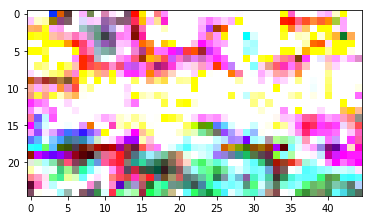

In [38]:
# LAB -> RGB로 변경하기
tsshow(lct.paramA.detach().cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


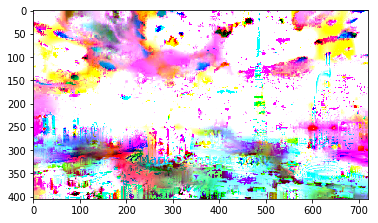

In [39]:
tsshow(a_upsampled.detach())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


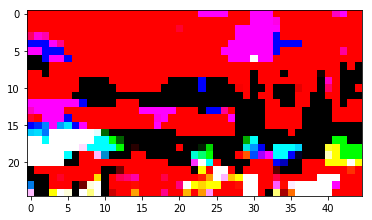

In [40]:
tsshow(lct.paramB.detach().cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


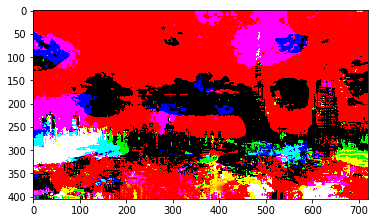

In [41]:
tsshow(b_upsampled.detach())

/home/seunghwan/anaconda3/envs/graduation/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 5878 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


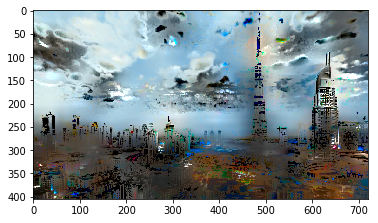

In [42]:
img5S = torch.unsqueeze(a_upsampled * labOrigS + b_upsampled, 0)
img5S = color.lab2rgb(img5S.detach().squeeze().cpu().numpy().transpose(1, 2, 0))
imshow(img5S)

In [43]:
img5S = torch.from_numpy(img5S.transpose(2, 0, 1)).float()
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img5S)
img5S = img5S.unsqueeze(0)

iteration: 1/5
iteration: 2/5
iteration: 3/5
iteration: 4/5
iteration: 5/5

iteration: 1/5
iteration: 2/5
iteration: 3/5
iteration: 4/5
iteration: 5/5
src_height: 49
src_width: 87
dest_height: 50
dest_width: 90
src_height: 49
src_width: 87
dest_height: 50
dest_width: 90
Iteration: 10/250 Loss: 9593.8701
Iteration: 20/250 Loss: 4001.8098
Iteration: 30/250 Loss: 1735.9635
Iteration: 40/250 Loss: 800.6734
Iteration: 50/250 Loss: 388.7144
Iteration: 60/250 Loss: 204.1560
Iteration: 70/250 Loss: 119.1482
Iteration: 80/250 Loss: 77.4635
Iteration: 90/250 Loss: 53.9320
Iteration: 100/250 Loss: 39.6906
Iteration: 110/250 Loss: 30.1669
Iteration: 120/250 Loss: 23.3770
Iteration: 130/250 Loss: 18.3207
Iteration: 140/250 Loss: 14.4427
Iteration: 150/250 Loss: 11.4154
Iteration: 160/250 Loss: 9.0276
Iteration: 170/250 Loss: 7.1344
Iteration: 180/250 Loss: 5.6294
Iteration: 190/250 Loss: 4.4321
Iteration: 200/250 Loss: 3.4798
Iteration: 210/250 Loss: 2.7233
Iteration: 220/250 Loss: 2.1233
Iteration

/home/seunghwan/anaconda3/envs/graduation/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 5058 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


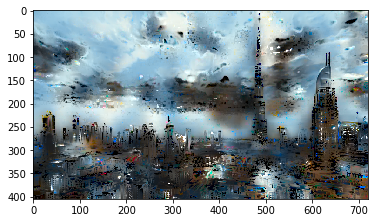

In [44]:
feat4S = get_feature(img5S, FEATURE_IDS[3])
feat4R = get_feature(imgR, FEATURE_IDS[3])
feat4S_norm = normalize(feat4S)
feat4R_norm = normalize(feat4R)

map4SR = PatchMatch(feat4S_norm, feat4R_norm) #S -> R
map4RS = PatchMatch(feat4R_norm, feat4S_norm) #R -> S
map4SR.solve()
print()
map4RS.solve()

imgS_resized = resize_img(origS, feat4S.shape[:2])
imgR_resized = resize_img(origR, feat4R.shape[:2])

imgG = bds_vote(map4SR.nnf.transpose(2, 0, 1), map4RS.nnf.transpose(2, 0, 1), map4SR.nnd, map4RS.nnd, imgR_resized)
feat4G = bds_vote(map4SR.nnf.transpose(2, 0, 1), map4RS.nnf.transpose(2, 0, 1), map4SR.nnd, map4RS.nnd, feat4R.transpose(2, 0, 1))
feat4G = feat4G.transpose(1, 2, 0)
feat4G_norm = normalize(feat4G)

labS = color.rgb2lab(imgS_resized.numpy().transpose(1, 2, 0))
labG = color.rgb2lab(imgG.transpose(1, 2, 0))

lct = LocalColorTransfer(labS, labG, feat4S_norm, feat4G_norm)
lct.train()

a_upsampled = FastGuidedFilter(1, eps=1e-08)(lct.source.unsqueeze(0).cpu(), lct.paramA.unsqueeze(0).cpu(), labOrigS.unsqueeze(0)).squeeze()
b_upsampled = FastGuidedFilter(1, eps=1e-08)(lct.source.unsqueeze(0).cpu(), lct.paramB.unsqueeze(0).cpu(), labOrigS.unsqueeze(0)).squeeze()

img4S = torch.unsqueeze(a_upsampled * labOrigS + b_upsampled, 0)
img4S = color.lab2rgb(img4S.detach().squeeze().cpu().numpy().transpose(1, 2, 0))
imshow(img4S)

In [45]:
img4S = torch.from_numpy(img4S.transpose(2, 0, 1)).float()
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img4S)
img4S = img4S.unsqueeze(0)

iteration: 1/5
iteration: 2/5
iteration: 3/5
iteration: 4/5
iteration: 5/5

iteration: 1/5
iteration: 2/5
iteration: 3/5
iteration: 4/5
iteration: 5/5
src_height: 98
src_width: 175
dest_height: 101
dest_width: 180
src_height: 98
src_width: 175
dest_height: 101
dest_width: 180
Iteration: 10/250 Loss: 4317.9194
Iteration: 20/250 Loss: 1765.9893
Iteration: 30/250 Loss: 823.1810
Iteration: 40/250 Loss: 421.2357
Iteration: 50/250 Loss: 232.2690
Iteration: 60/250 Loss: 138.1633
Iteration: 70/250 Loss: 86.6961
Iteration: 80/250 Loss: 57.0674
Iteration: 90/250 Loss: 38.7502
Iteration: 100/250 Loss: 26.8823
Iteration: 110/250 Loss: 18.9527
Iteration: 120/250 Loss: 13.5327
Iteration: 130/250 Loss: 9.7754
Iteration: 140/250 Loss: 7.1394
Iteration: 150/250 Loss: 5.2723
Iteration: 160/250 Loss: 3.9377
Iteration: 170/250 Loss: 2.9746
Iteration: 180/250 Loss: 2.2723
Iteration: 190/250 Loss: 1.7544
Iteration: 200/250 Loss: 1.3677
Iteration: 210/250 Loss: 1.0754
Iteration: 220/250 Loss: 0.8515
Iteratio

/home/seunghwan/anaconda3/envs/graduation/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 2976 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


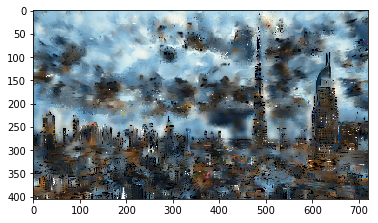

In [46]:
feat3S = get_feature(img4S, FEATURE_IDS[2])
feat3R = get_feature(imgR, FEATURE_IDS[2])
feat3S_norm = normalize(feat3S)
feat3R_norm = normalize(feat3R)

map3SR = PatchMatch(feat3S_norm, feat3R_norm) #S -> R
map3RS = PatchMatch(feat3R_norm, feat3S_norm) #R -> S
map3SR.solve()
print()
map3RS.solve()

imgS_resized = resize_img(origS, feat3S.shape[:2])
imgR_resized = resize_img(origR, feat3R.shape[:2])

imgG = bds_vote(map3SR.nnf.transpose(2, 0, 1), map3RS.nnf.transpose(2, 0, 1), map3SR.nnd, map3RS.nnd, imgR_resized)
feat3G = bds_vote(map3SR.nnf.transpose(2, 0, 1), map3RS.nnf.transpose(2, 0, 1), map3SR.nnd, map3RS.nnd, feat3R.transpose(2, 0, 1))
feat3G = feat3G.transpose(1, 2, 0)
feat3G_norm = normalize(feat3G)

labS = color.rgb2lab(imgS_resized.numpy().transpose(1, 2, 0))
labG = color.rgb2lab(imgG.transpose(1, 2, 0))

lct = LocalColorTransfer(labS, labG, feat3S_norm, feat3G_norm)
lct.train()

a_upsampled = FastGuidedFilter(1, eps=1e-08)(lct.source.unsqueeze(0).cpu(), lct.paramA.unsqueeze(0).cpu(), labOrigS.unsqueeze(0)).squeeze()
b_upsampled = FastGuidedFilter(1, eps=1e-08)(lct.source.unsqueeze(0).cpu(), lct.paramB.unsqueeze(0).cpu(), labOrigS.unsqueeze(0)).squeeze()

img3S = torch.unsqueeze(a_upsampled * labOrigS + b_upsampled, 0)
img3S = color.lab2rgb(img3S.detach().squeeze().cpu().numpy().transpose(1, 2, 0))
imshow(img3S)

In [47]:
img3S = torch.from_numpy(img3S.transpose(2, 0, 1)).float()
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img3S)
img3S = img3S.unsqueeze(0)

iteration: 1/5
iteration: 2/5
iteration: 3/5
iteration: 4/5
iteration: 5/5

iteration: 1/5
iteration: 2/5
iteration: 3/5
iteration: 4/5
iteration: 5/5
src_height: 197
src_width: 350
dest_height: 202
dest_width: 360
src_height: 197
src_width: 350
dest_height: 202
dest_width: 360
Iteration: 10/250 Loss: 1546.5957
Iteration: 20/250 Loss: 645.7857
Iteration: 30/250 Loss: 299.2332
Iteration: 40/250 Loss: 153.2767
Iteration: 50/250 Loss: 85.4609
Iteration: 60/250 Loss: 51.1900
Iteration: 70/250 Loss: 32.5927
Iteration: 80/250 Loss: 21.7926
Iteration: 90/250 Loss: 15.1012
Iteration: 100/250 Loss: 10.7379
Iteration: 110/250 Loss: 7.7895
Iteration: 120/250 Loss: 5.7407
Iteration: 130/250 Loss: 4.2856
Iteration: 140/250 Loss: 3.2335
Iteration: 150/250 Loss: 2.4613
Iteration: 160/250 Loss: 1.8873
Iteration: 170/250 Loss: 1.4562
Iteration: 180/250 Loss: 1.1295
Iteration: 190/250 Loss: 0.8801
Iteration: 200/250 Loss: 0.6884
Iteration: 210/250 Loss: 0.5402
Iteration: 220/250 Loss: 0.4252
Iteration: 

/home/seunghwan/anaconda3/envs/graduation/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 1485 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


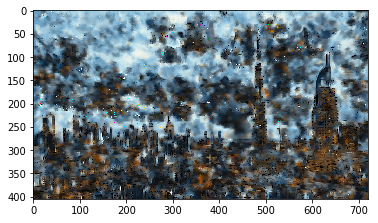

In [48]:
feat2S = get_feature(img3S, FEATURE_IDS[1])
feat2R = get_feature(imgR, FEATURE_IDS[1])
feat2S_norm = normalize(feat2S)
feat2R_norm = normalize(feat2R)

map2SR = PatchMatch(feat2S_norm, feat2R_norm) #S -> R
map2RS = PatchMatch(feat2R_norm, feat2S_norm) #R -> S
map2SR.solve()
print()
map2RS.solve()

imgS_resized = resize_img(origS, feat2S.shape[:2])
imgR_resized = resize_img(origR, feat2R.shape[:2])

imgG = bds_vote(map2SR.nnf.transpose(2, 0, 1), map2RS.nnf.transpose(2, 0, 1), map2SR.nnd, map2RS.nnd, imgR_resized)
feat2G = bds_vote(map2SR.nnf.transpose(2, 0, 1), map2RS.nnf.transpose(2, 0, 1), map2SR.nnd, map2RS.nnd, feat2R.transpose(2, 0, 1))
feat2G = feat2G.transpose(1, 2, 0)
feat2G_norm = normalize(feat2G)

labS = color.rgb2lab(imgS_resized.numpy().transpose(1, 2, 0))
labG = color.rgb2lab(imgG.transpose(1, 2, 0))

lct = LocalColorTransfer(labS, labG, feat2S_norm, feat2G_norm)
lct.train()

a_upsampled = FastGuidedFilter(1, eps=1e-08)(lct.source.unsqueeze(0).cpu(), lct.paramA.unsqueeze(0).cpu(), labOrigS.unsqueeze(0)).squeeze()
b_upsampled = FastGuidedFilter(1, eps=1e-08)(lct.source.unsqueeze(0).cpu(), lct.paramB.unsqueeze(0).cpu(), labOrigS.unsqueeze(0)).squeeze()

img2S = torch.unsqueeze(a_upsampled * labOrigS + b_upsampled, 0)
img2S = color.lab2rgb(img2S.detach().squeeze().cpu().numpy().transpose(1, 2, 0))
imshow(img2S)

In [49]:
img2S = torch.from_numpy(img2S.transpose(2, 0, 1)).float()
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img2S)
img2S = img2S.unsqueeze(0)

iteration: 1/5
iteration: 2/5
iteration: 3/5
iteration: 4/5
iteration: 5/5

iteration: 1/5
iteration: 2/5
iteration: 3/5
iteration: 4/5
iteration: 5/5
src_height: 394
src_width: 700
dest_height: 405
dest_width: 720
src_height: 394
src_width: 700
dest_height: 405
dest_width: 720
Iteration: 10/250 Loss: 353.5269
Iteration: 20/250 Loss: 131.9908
Iteration: 30/250 Loss: 57.5615
Iteration: 40/250 Loss: 29.3592
Iteration: 50/250 Loss: 16.6648
Iteration: 60/250 Loss: 10.3348
Iteration: 70/250 Loss: 6.9952
Iteration: 80/250 Loss: 5.0683
Iteration: 90/250 Loss: 3.8456
Iteration: 100/250 Loss: 3.0115
Iteration: 110/250 Loss: 2.4145
Iteration: 120/250 Loss: 1.9713
Iteration: 130/250 Loss: 1.6322
Iteration: 140/250 Loss: 1.3669
Iteration: 150/250 Loss: 1.1556
Iteration: 160/250 Loss: 0.9848
Iteration: 170/250 Loss: 0.8448
Iteration: 180/250 Loss: 0.7289
Iteration: 190/250 Loss: 0.6319
Iteration: 200/250 Loss: 0.5502
Iteration: 210/250 Loss: 0.4807
Iteration: 220/250 Loss: 0.4213
Iteration: 230/250

/home/seunghwan/anaconda3/envs/graduation/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 66 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


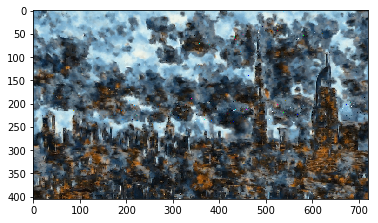

In [50]:
feat1S = get_feature(img2S, FEATURE_IDS[0])
feat1R = get_feature(imgR, FEATURE_IDS[0])
feat1S_norm = normalize(feat1S)
feat1R_norm = normalize(feat1R)

map1SR = PatchMatch(feat1S_norm, feat1R_norm) #S -> R
map1RS = PatchMatch(feat1R_norm, feat1S_norm) #R -> S
map1SR.solve()
print()
map1RS.solve()

imgS_resized = resize_img(origS, feat1S.shape[:2])
imgR_resized = resize_img(origR, feat1R.shape[:2])

imgG = bds_vote(map1SR.nnf.transpose(2, 0, 1), map1RS.nnf.transpose(2, 0, 1), map1SR.nnd, map1RS.nnd, imgR_resized)
feat1G = bds_vote(map1SR.nnf.transpose(2, 0, 1), map1RS.nnf.transpose(2, 0, 1), map1SR.nnd, map1RS.nnd, feat1R.transpose(2, 0, 1))
feat1G = feat1G.transpose(1, 2, 0)
feat1G_norm = normalize(feat1G)

labS = color.rgb2lab(imgS_resized.numpy().transpose(1, 2, 0))
labG = color.rgb2lab(imgG.transpose(1, 2, 0))

lct = LocalColorTransfer(labS, labG, feat1S_norm, feat1G_norm)
lct.train()

a_upsampled = FastGuidedFilter(1, eps=1e-08)(lct.source.unsqueeze(0).cpu(), lct.paramA.unsqueeze(0).cpu(), labOrigS.unsqueeze(0)).squeeze()
b_upsampled = FastGuidedFilter(1, eps=1e-08)(lct.source.unsqueeze(0).cpu(), lct.paramB.unsqueeze(0).cpu(), labOrigS.unsqueeze(0)).squeeze()

img1S = torch.unsqueeze(a_upsampled * labOrigS + b_upsampled, 0)
img1S = color.lab2rgb(img1S.detach().squeeze().cpu().numpy().transpose(1, 2, 0))
imshow(img1S)